In [98]:
import pandas as pd
from statsmodels.tsa.stattools import adfuller
import statsmodels.tsa.stattools as st
import numpy as np
import pyflux as pf


# daily_payment = pd.read_csv('xxx.csv',parse_dates=[0], index_col=0)


def obtain_data():
    dateparse = lambda dates: pd.datetime.strptime(dates, '%Y')
    return pd.read_csv('data_armia.csv', parse_dates=['year'], index_col='year', date_parser=dateparse)


def test_stationarity(timeseries):
    dftest = adfuller(timeseries, autolag='AIC')
    return dftest[1]


def best_diff(df, maxdiff = 8):
    p_set = {}
    for i in range(0, maxdiff):
        temp = df.copy() #每次循环前，重置
        if i == 0:
            # temp['diff'] = temp[temp.columns[1]]
            temp['diff'] = temp[temp.columns[0]]
        else:
            # temp['diff'] = temp[temp.columns[1]].diff(i)
            temp['diff'] = temp[temp.columns[0]].diff(i)
            temp = temp.drop(temp.iloc[:i].index) #差分后，前几行的数据会变成nan，所以删掉
        pvalue = test_stationarity(temp['diff'])
        p_set[i] = pvalue
        p_df = pd.DataFrame.from_dict(p_set, orient="index")
        p_df.columns = ['p_value']
    i = 0
    while i < len(p_df):
        if p_df['p_value'][i]<0.01:
            bestdiff = i
            break
        i += 1
    return bestdiff


def produce_diffed_timeseries(df, diffn):
    if diffn != 0:
        df['diff'] = df[df.columns[1]].apply(lambda x:float(x)).diff(diffn)
    else:
        df['diff'] = df[df.columns[1]].apply(lambda x:float(x))
    df.dropna(inplace=True) #差分之后的nan去掉
    return df


def choose_order(ts, maxar, maxma):
    order = st.arma_order_select_ic(ts, maxar, maxma, ic=['aic', 'bic', 'hqic'])
    return order.bic_min_order


def predict_recover(ts, df, diffn):
    if diffn != 0:
        ts.iloc[0] = ts.iloc[0]+df['log'][-diffn]
        ts = ts.cumsum()
    ts = np.exp(ts)
#    ts.dropna(inplace=True)
    print('还原完成')
    return ts



In [99]:
df = obtain_data()

In [103]:
data = df.dropna()
data['log'] = np.log(data[data.columns[0]])

#train_size = len(data)-int(14)
#train, test = data[:train_size], data[train_size:]
train = data
# stationarity of log value

差分阶数为2，已完成差分
开始进行ARMA拟合
模型的阶数为：(0, 4)


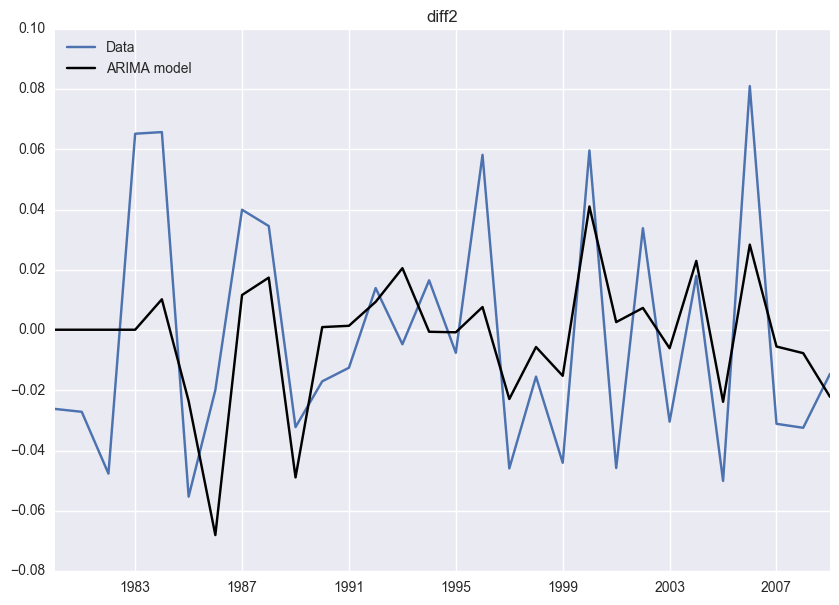

In [108]:
#diffn = best_diff(train, maxdiff=8)
diffn = 2
for i in range(1,diffn+1):
    train["diff{}".format(i)]=train[train.columns[i]].diff(1)
    train = train.drop(train.iloc[:1].index) #差分后，前几行的数据会变成nan，所以删掉
train = produce_diffed_timeseries(train, diffn)

print('差分阶数为'+str(diffn)+'，已完成差分')
print('开始进行ARMA拟合')

order = choose_order(train[train.columns[diffn+1]], 5, 5)
print('模型的阶数为：'+str(order))
_ar = order[0]
_ma = order[1]
model = pf.ARIMA(data=train, ar=_ar, ma=_ma, target='diff2', family=pf.Normal())
model.fit("MLE")
model.plot_fit()

In [110]:
test_predict = model.predict(5)

AttributeError: module 'pandas.core' has no attribute 'indexes'